LAICA2 mirror size, GJ 436
=====================

In this notebook we will walk through how to estimate the expected count rate of LAICA2 for a given mirror size.

Let's first import some useful Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import matplotlib.pylab as pylab
from scipy.integrate import simps

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

Now we load the information about GJ 436's Lyman-$\alpha$ emission:

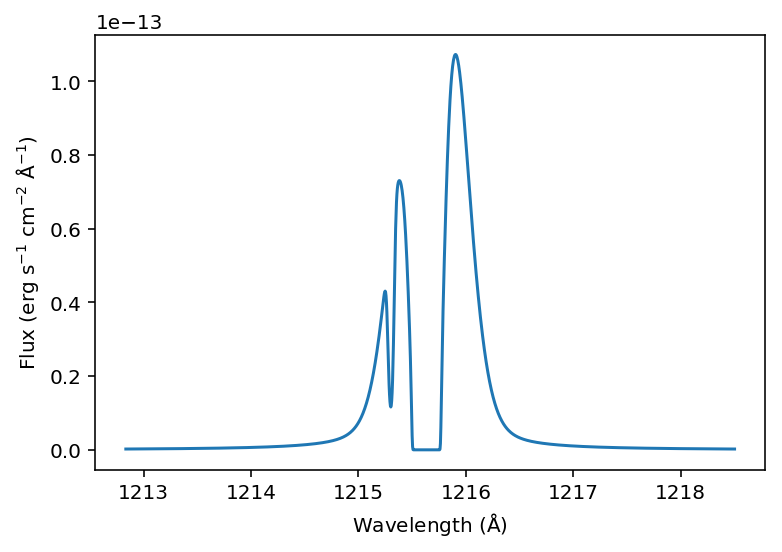

In [2]:
d = np.loadtxt('GJ436-EmissionLine_Abs_HI.d')

# Data is at a distance of 1 AU, change it to stellar distance
distance = 10.3 * u.pc
d_AU = distance.to(u.AU).value
d[:, 1] *= 1 / d_AU ** 2

# Plot the spectrum
plt.plot(d[:, 0], d[:, 1])
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$)')
plt.show()

Load information about the efficiencies of the instrument:

In [3]:
filter_d = np.loadtxt('LAICA_filter')
mirror_d = np.loadtxt('LAICA_mirror')

# Filter transmittance and mirror reflectance
f_t = (filter_d[3, 1] + filter_d[4, 1]) / 2 / 100
m_r = mirror_d[1, 1] / 100

# Detector quantum efficiency
d_e = 0.30

# Throughput 
th = f_t * m_r * d_e
print('Expected throughput = %f' % th)

Expected throughput = 0.053367


We need to transform the stellar flux into number of photons:

Mean photon energy = 1.634039e-11 erg


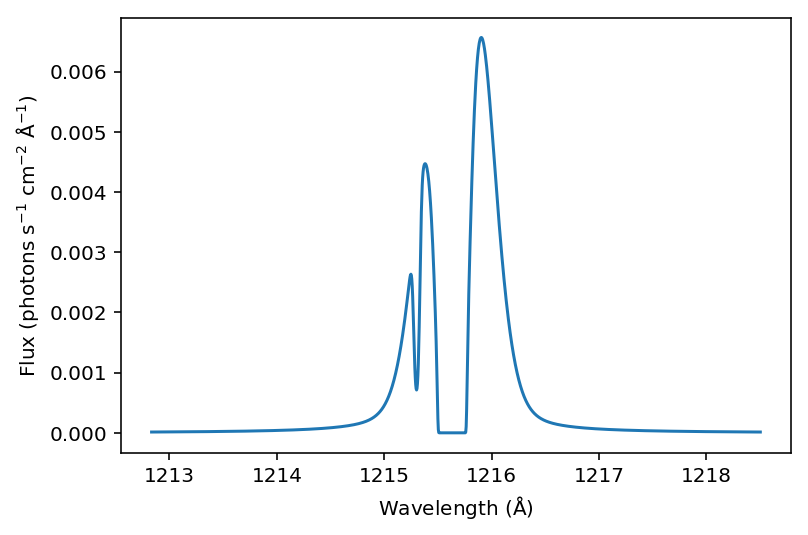

In [4]:
ph_energy = (c.h * c.c / (d[:, 0] * u.angstrom)).to(u.erg).value
print('Mean photon energy = %e erg' % np.mean(ph_energy))
n_ph = d[:, 1] / ph_energy
plt.plot(d[:, 0], n_ph)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel(r'Flux (photons s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$)')
plt.show()

Now we integrate the Lyman-$\alpha$ flux in the wavelength range of the line to obtain the flux in photons / s / cm$^2$:

In [5]:
lya_flux = simps(n_ph, d[:, 0])
print(r'Lyman-alpha flux = %e photons / s / cm^2' % lya_flux)

Lyman-alpha flux = 3.234597e-03 photons / s / cm^2


We need to convert this flux to Rayleigh in order to estimate the count rate in the detector. The star is not an extended object, so we adopt a circular aperture based on the FWHM of the instrument.

In [6]:
fwhm = 2  # pixels
theta = fwhm * 0.024 * u.deg
omega = 2 * np.pi * (1 - np.cos(theta))  # Solid angle of the circular aperture in sr
lya_rad = lya_flux / omega * 1E-6 * 4 * np.pi
print('Lyman-alpha radiance in a circular aperture with radius 2 px = %e R' % lya_rad)

Lyman-alpha radiance in a circular aperture with radius 2 px = 1.843499e-02 R


The "effective sensitivity" of the detector is 0.0011 cts / s / pix / R. The mirror size of the Cassegrain telescope was 41 mm. We need to convert that to cts / photon detected:

In [7]:
px_size = 0.024 * u.deg
diam_original = (41 * u.mm).to(u.cm).value
px_aperture = 2 * np.pi * (1 - np.cos(px_size))  # Ster-radians
sens = 1.1E-3 / px_aperture * 1E-6 / (4 * np.pi) * np.pi * (diam_original / 2) ** 2 # count / photon
print('Detector sensitivity = %e counts / photon' % sens)

Detector sensitivity = 2.096589e-03 counts / photon


Finally, we compute the expected count rate of the Lyman-$\alpha$ flux of GJ 436:

In [8]:
tel_d = 10 * u.cm
area = (np.pi * (tel_d / 2) ** 2).to(u.cm ** 2).value
lya_flux_detector = area * lya_flux  # Photons / s

print('Lyman-a flux at the detector = %e photons / s' % lya_flux_detector)

# The expected count rate in counts / s
rate = lya_flux_detector * sens
print('\nCount rate for a 10 cm telescope = %e cts / s'% rate)

tel_d = 20 * u.cm
area = (np.pi * (tel_d / 2) ** 2).to(u.cm ** 2).value
lya_flux_detector = area * lya_flux  # Photons / s

rate = lya_flux_detector * sens
print('Count rate for a 20 cm telescope = %e cts / s'% rate)

print('\nFor comparison, the dark level of LAICA is %.1e cts / s / px' % 2E-4)

Lyman-a flux at the detector = 2.540446e-01 photons / s

Count rate for a 10 cm telescope = 5.326272e-04 cts / s
Count rate for a 20 cm telescope = 2.130509e-03 cts / s

For comparison, the dark level of LAICA is 2.0e-04 cts / s / px
